# 将模型预测的参数值可视化出来

## 导入所有信息

### 导入依赖

In [ ]:
import json
import os
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()
sys.path.append(os.getenv("PROJ_PATH"))  # type: ignore

from dmg.core.post.plot_parameters import plot_parameters  # noqa
from project.better_estimate import load_config  # noqa

### 导入配置

In [ ]:
config = load_config(r"conf/config_dhbv_hopev2.yaml")
out_path = config["out_path"]

### 加载数据

In [ ]:
from dmg.core.data.loaders import HydroLoader   # noqa

loader = HydroLoader(config, test_split=True, overwrite=False)
loader.load_dataset()
eval_dataset = loader.eval_dataset

### 加载流域ids

In [ ]:
with open(os.path.join(os.getenv("DATA_PATH"), "531sub_id.txt"), "r") as f:
    selected_basins = np.array(json.load(f))

## 构建模型

In [ ]:
from dmg import ModelHandler
from dmg.core.utils import import_trainer  # noqa
config['mode'] = 'test'
config['test']['test_epoch'] = 5
model = ModelHandler(config, verbose=True)
trainer_cls = import_trainer(config['trainer'])
trainer = trainer_cls(
    config,
    model,
    eval_dataset=eval_dataset,
    verbose=True,
)
nn_model = trainer.model.model_dict['Hbv_2'].nn_model
hope_layer = nn_model.hope_layer

## 得到模型输出结果

In [ ]:
import torch
model_input = eval_dataset['xc_nn_norm']
select_basin_idx = np.where(selected_basins==8023080)[0][0]
print(select_basin_idx)
tmp_model_input = model_input[0:730, select_basin_idx:select_basin_idx+1, :]
print(model_input.shape)
layer_output = hope_layer(torch.permute(tmp_model_input, (1, 0, 2)))
layer_output = torch.sigmoid(layer_output.reshape(-1, 3, 16))
print(layer_output.shape)

## 绘制模型预测结果

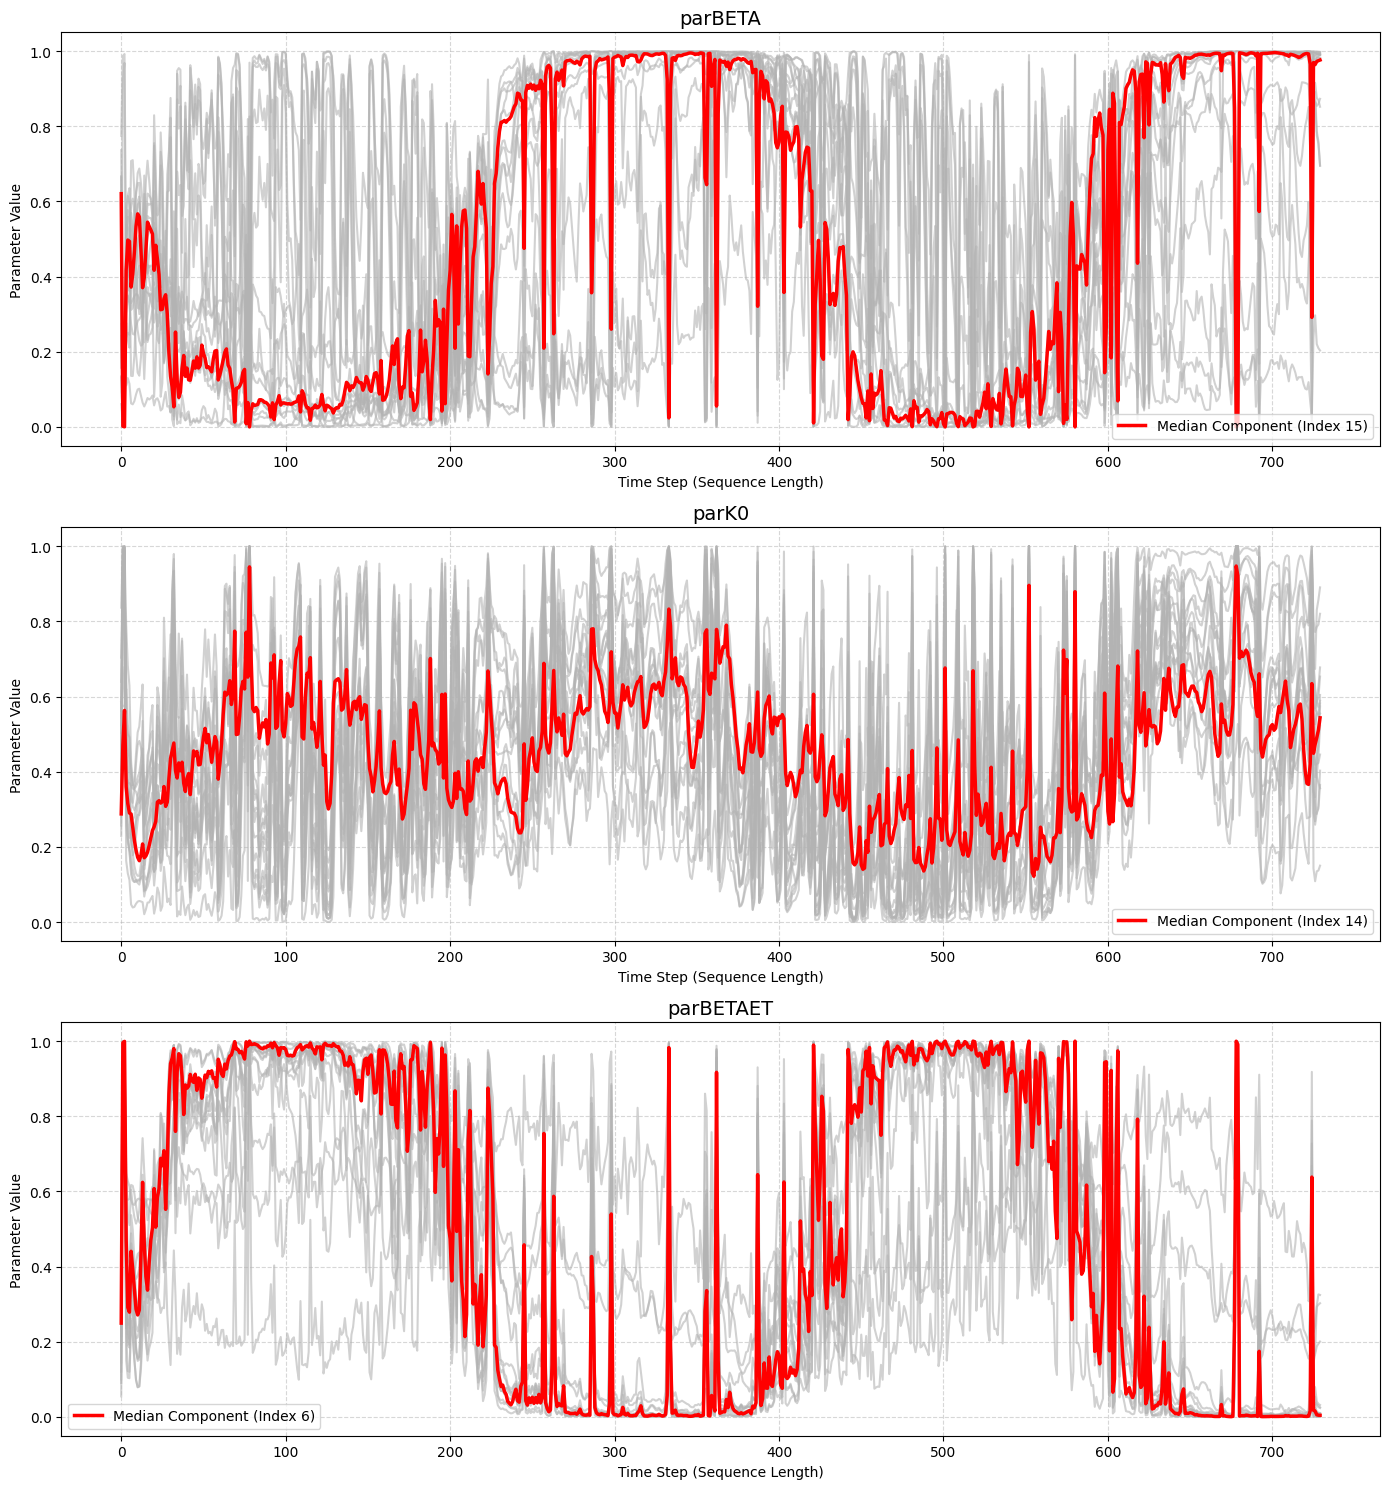

In [8]:
timevar_params = layer_output.permute(0,2,1).detach().cpu().numpy()
titles = ['parBETA', 'parK0', 'parBETAET']
plot_parameters(timevar_params, titles=titles, median_color='red')
plt.show()